Symulacje zakończone. Generowanie wykresów.


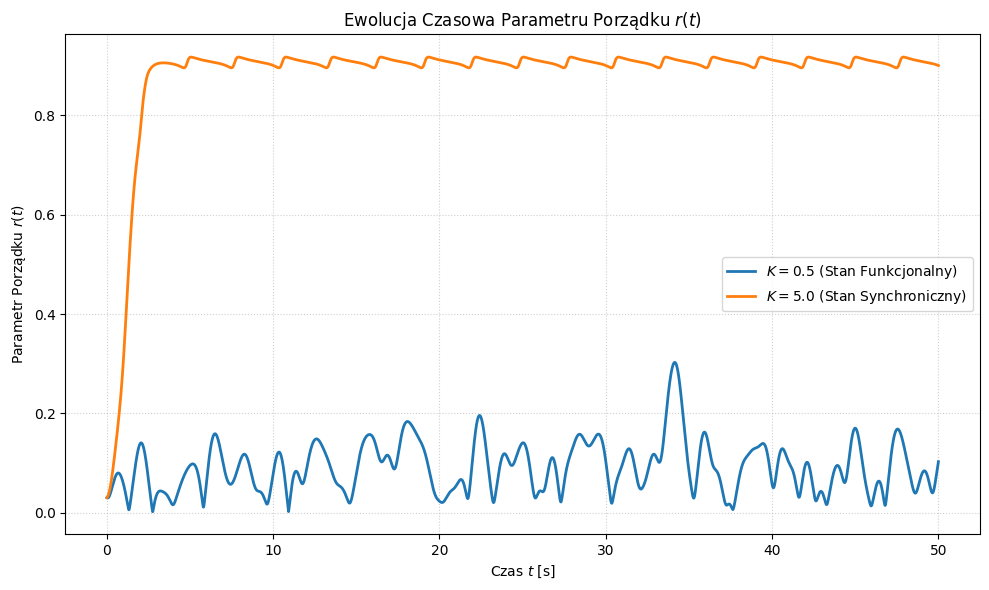

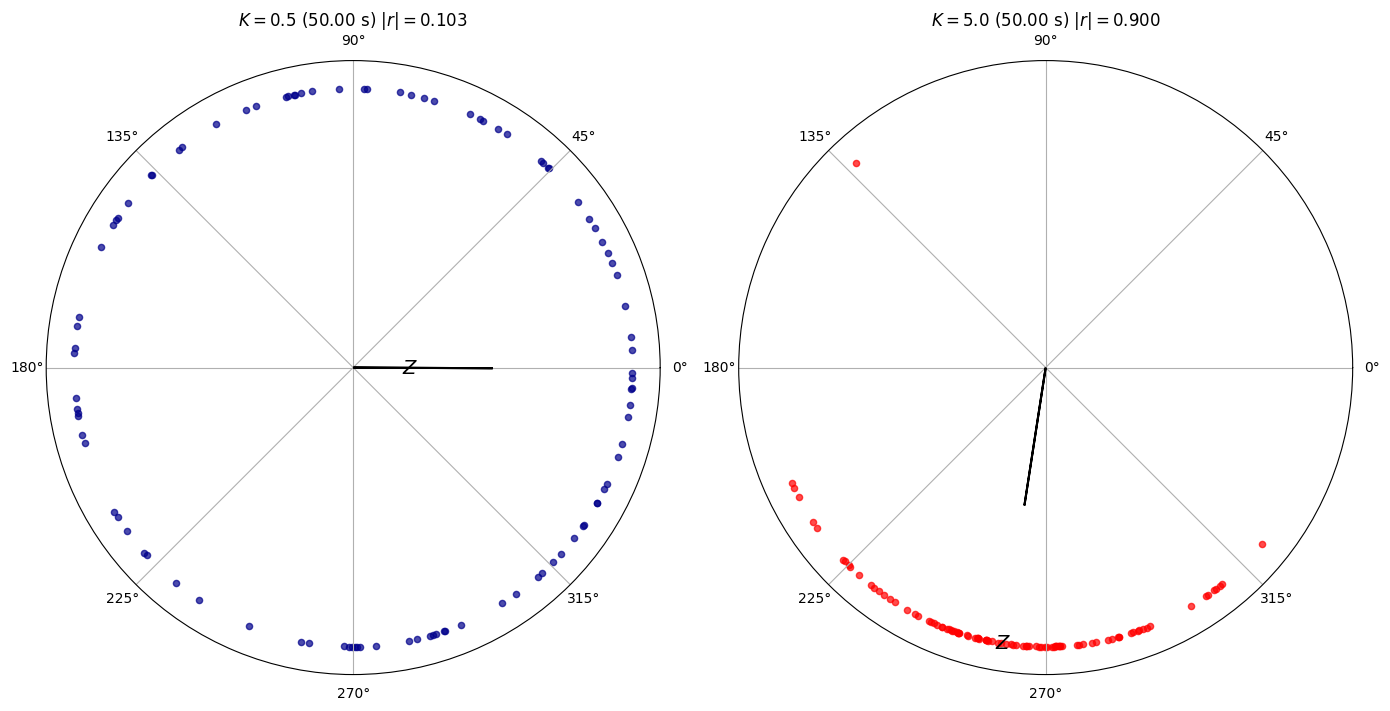

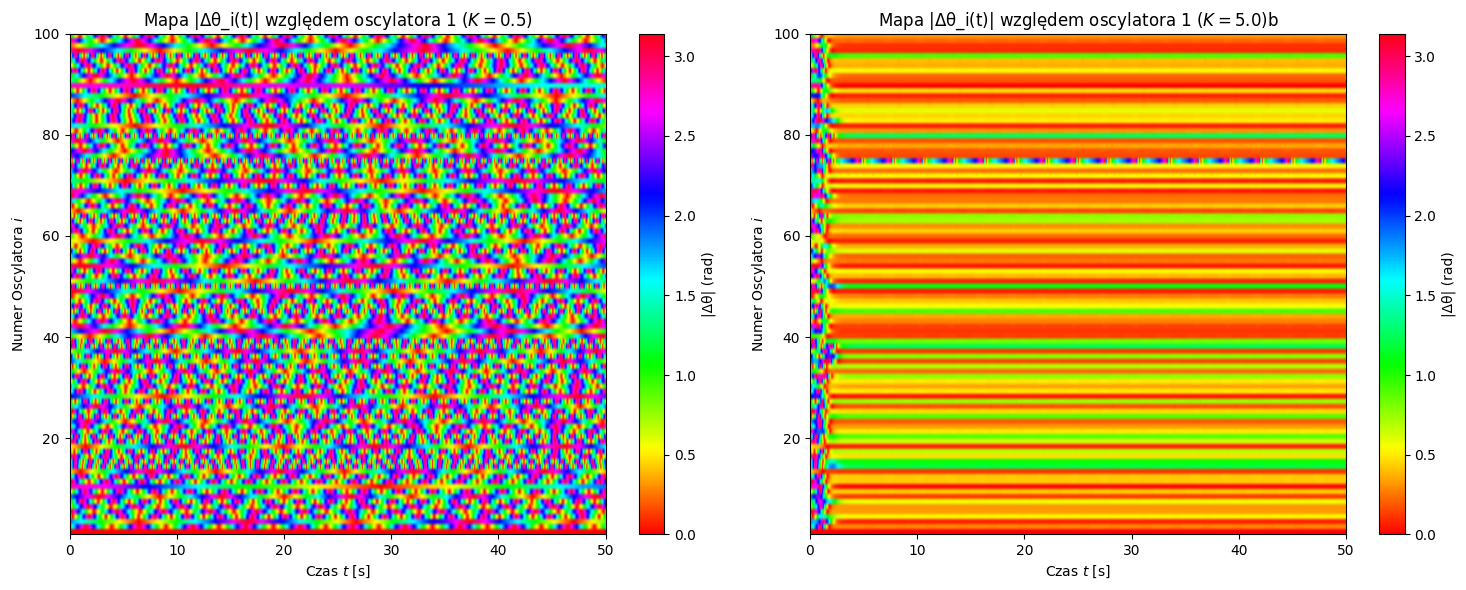

In [26]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(1)
# --- STAŁE FIZYCZNE I NUMERYCZNE ---
CONST = {
    "N": 100,
    "DT": 0.005,
    "NT": 10000,
    "T_MAX": 50.0,
    "MU_OMEGA": 40.0,
    "SIGMA_OMEGA": 2.0,
    "K_FUNC": 0.5,
    "K_SYNC": 5.0,
    "T_PLOT": 50.0
}

# --- GENEROWANIE WARUNKÓW POCZĄTKOWYCH I CZĘSTOŚCI ---
def initial_setup(N, MU_OMEGA, SIGMA_OMEGA, seed=42):
    np.random.seed(seed)
    omega_i = np.random.normal(MU_OMEGA, SIGMA_OMEGA, N)
    theta_0 = 2 * np.pi * np.random.rand(N)
    return theta_0, omega_i

# --- FUNKCJA DYNAMIKI (PRAWA STRONA RRZ) ---
def dynamics_function(t, theta, K, omega_i):
    # Z = (1/N) * sum_j e^{i theta_j}
    Z = np.mean(np.exp(1j * theta))
    # dtheta_i/dt = omega_i + K * Im( e^{-i theta_i} * Z )
    coupling = K * np.imag(np.exp(-1j * theta) * Z)
    dtheta_dt = omega_i + coupling
    return dtheta_dt

# --- SYMULACJA (RK4), zwraca cały przebieg jeśli need_full=True ---
def simulate(K, theta_0, omega_i, CONST, need_full=False):
    N = CONST["N"]
    DT = CONST["DT"]
    NT = CONST["NT"]
    T_PLOT = CONST["T_PLOT"]
    T_MAX = CONST["T_MAX"]

    Times = np.linspace(0, T_MAX, NT + 1)
    Order_Parameter_R = np.zeros(NT + 1)
    Theta_Matrix = np.zeros((NT + 1, N)) if need_full else None

    theta = theta_0.copy()

    Z_0 = np.mean(np.exp(1j * theta))
    Order_Parameter_R[0] = np.abs(Z_0)
    if need_full:
        Theta_Matrix[0, :] = theta.copy()

    index_T_PLOT = int(round(T_PLOT / DT))
    if index_T_PLOT > NT:
        raise ValueError("T_PLOT is larger than simulation time. Adjust T_PLOT or NT/DT.")

    for n in range(NT):
        t = Times[n]
        func = lambda tt, th: dynamics_function(tt, th, K, omega_i)

        k1 = func(t, theta)
        k2 = func(t + 0.5 * DT, theta + 0.5 * DT * k1)
        k3 = func(t + 0.5 * DT, theta + 0.5 * DT * k2)
        k4 = func(t + DT, theta + DT * k3)

        theta = theta + (DT / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        theta = np.mod(theta, 2 * np.pi)

        Z_n = np.mean(np.exp(1j * theta))
        Order_Parameter_R[n + 1] = np.abs(Z_n)
        if need_full:
            Theta_Matrix[n + 1, :] = theta.copy()

    final_theta = None
    if need_full:
        final_theta = Theta_Matrix[index_T_PLOT, :]
    else:
        final_theta = None

    return Times, Order_Parameter_R, final_theta, Theta_Matrix

# --- PRZEBIEG GŁÓWNY ---
theta_0, omega_i = initial_setup(CONST["N"], CONST["MU_OMEGA"], CONST["SIGMA_OMEGA"], seed=42)

# Uruchamiamy symulację i przechowujemy pełne przebiegi (tańsze: uruchomić tylko raz z dwoma K jeśli potrzeba)
Times_func, R_func, _, Theta_Matrix_func = simulate(CONST["K_FUNC"], theta_0, omega_i, CONST, need_full=True)
Times_sync, R_sync, _, Theta_Matrix_sync = simulate(CONST["K_SYNC"], theta_0, omega_i, CONST, need_full=True)

# Fazy w czasie T_PLOT
index_T_PLOT = int(round(CONST["T_PLOT"] / CONST["DT"]))
Theta_func = Theta_Matrix_func[index_T_PLOT, :]
Theta_sync = Theta_Matrix_sync[index_T_PLOT, :]

print("Symulacje zakończone. Generowanie wykresów.")

# --- WIZUALIZACJA WYNIKÓW ---

# 1. Ewolucja parametru porządku r(t)
plt.figure(figsize=(10, 6))
plt.plot(Times_func, R_func, label=f'$K={CONST["K_FUNC"]}$ (Stan Funkcjonalny)', linewidth=2)
plt.plot(Times_sync, R_sync, label=f'$K={CONST["K_SYNC"]}$ (Stan Synchroniczny)', linewidth=2)
plt.title('Ewolucja Czasowa Parametru Porządku $r(t)$')
plt.xlabel('Czas $t$ [s]')
plt.ylabel('Parametr Porządku $r(t)$')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# 2. Wykresy faz radialne (polarne) dla faz theta_i(t=T_PLOT)
# K_FUNC
Z_func = np.mean(np.exp(1j * Theta_func))
R_func_final = np.abs(Z_func)
Psi_func = np.angle(Z_func)

# K_SYNC
Z_sync = np.mean(np.exp(1j * Theta_sync))
R_sync_final = np.abs(Z_sync)
Psi_sync = np.angle(Z_sync)

fig, axes = plt.subplots(1, 2, figsize=(14, 7), subplot_kw={'projection': 'polar'})
T_PLOT_label = CONST["T_PLOT"]

# --- WYKRES DLA K = 0.5 (STAN FUNKCJONALNY) ---
axes[0].scatter(Theta_func, np.ones(CONST["N"]), s=20, alpha=0.7, color='darkblue')
axes[0].set_title(f'$K={CONST["K_FUNC"]}$ ({T_PLOT_label:.2f} s) $|r| = {R_func_final:.3f}$')
axes[0].set_yticks([])
axes[0].set_rlim(0, 1.1) # Ustawia limit promienia

# Dodanie wektora Z (parametr porządku)
axes[0].arrow(
    Psi_func, 0, R_func_final, 0,
    fc='k', ec='k', linewidth=1.5, zorder=10,
    head_width=1,
    head_length=R_func_final,
    length_includes_head=True
)
axes[0].text(Psi_func, R_func_final + 0.1, '$Z$', fontsize=14, ha='center', va='center')


# --- WYKRES DLA K = 5.0 (STAN SYNCHRONICZNY) ---
axes[1].scatter(Theta_sync, np.ones(CONST["N"]), s=20, color='r', alpha=0.7)
axes[1].set_title(f'$K={CONST["K_SYNC"]}$ ({T_PLOT_label:.2f} s) $|r| = {R_sync_final:.3f}$')
axes[1].set_yticks([])
axes[1].set_rlim(0, 1.1)

axes[1].arrow(
    Psi_sync, 0, R_sync_final, 0,
    fc='k', ec='k', linewidth=1.5, zorder=10,
    head_width=1,
    head_length=R_sync_final,
    length_includes_head=True,
)
axes[1].text(Psi_sync, R_sync_final + 0.1, '$Z$', fontsize=14, ha='center', va='center')


plt.tight_layout()
plt.show()


# 3. Mapy różnic faz względem oscylatora referencyjnego ref_index
ref_index = 0  # referencyjny oscylator

def phase_diff_matrix(Theta_Matrix, ref_index):
    ref = Theta_Matrix[:, ref_index][:, None]   # (time,1)
    diff = Theta_Matrix - ref

    diff_wrapped = (diff + np.pi) % (2 * np.pi) - np.pi
    return np.abs(diff_wrapped)

Map_func = phase_diff_matrix(Theta_Matrix_func, ref_index)
Map_sync = phase_diff_matrix(Theta_Matrix_sync, ref_index)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

im1 = axes[0].imshow(
    Map_func.T,
    aspect='auto',
    origin='lower',
    extent=[0, CONST["T_MAX"], 1, CONST["N"]],
    cmap='hsv',
    vmin=0.0,
    vmax=np.pi
)
axes[0].set_title(f'Mapa |Δθ_i(t)| względem oscylatora {ref_index+1} ($K={CONST["K_FUNC"]}$)')
axes[0].set_xlabel('Czas $t$ [s]')
axes[0].set_ylabel('Numer Oscylatora $i$')
fig.colorbar(im1, ax=axes[0], label='|Δθ| (rad)')

im2 = axes[1].imshow(
    Map_sync.T,
    aspect='auto',
    origin='lower',
    extent=[0, CONST["T_MAX"], 1, CONST["N"]],
    cmap='hsv',
    vmin=0.0,
    vmax=np.pi
)
axes[1].set_title(f'Mapa |Δθ_i(t)| względem oscylatora {ref_index+1} ($K={CONST["K_SYNC"]}$)b')
axes[1].set_xlabel('Czas $t$ [s]')
axes[1].set_ylabel('Numer Oscylatora $i$')
fig.colorbar(im2, ax=axes[1], label='|Δθ| (rad)')

plt.tight_layout()
plt.show()
